In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Load the Titanic Dataset
# Make sure 'titanic.csv' is in the same directory as your script,
# or provide the full path to the file.
df = pd.read_csv('titanic.csv')

print("Titanic Dataset (first 5 rows):")
print(df.head())
print(f"\nDataset Info:")
df.info()

Titanic Dataset (first 5 rows):
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373

In [4]:
# 1. Prepare the Data
# Define target and features
# Our target variable will be 'Survived'
# Features will include 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'
X = df.drop('Survived', axis=1)
y = df['Survived']

# Identify numerical and categorical features
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked'] # 'Pclass' is treated as categorical here
# 'Name', 'Ticket', 'Cabin', 'PassengerId' are typically dropped or require more advanced feature engineering

# Create preprocessing pipelines for numerical and categorical features
# Numerical pipeline: Impute missing 'Age' values with the mean, then scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: Impute missing 'Embarked' values with the most frequent, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Drops columns not specified in transformers
)

# Apply preprocessing to the entire dataset (this step is part of the pipeline below, but shown for clarity)
X_processed = preprocessor.fit_transform(X)
print("Processed Data (first 5 rows - numerical and one-hot encoded categorical):")
print(pd.DataFrame(X_processed).head()) # This might be sparse if many categories


Processed Data (first 5 rows - numerical and one-hot encoded categorical):
         0         1         2         3    4    5    6    7    8    9    10  \
0 -0.592481  0.432793 -0.473674 -0.502445  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
1  0.638789  0.432793 -0.473674  0.786845  1.0  0.0  0.0  1.0  0.0  1.0  0.0   
2 -0.284663 -0.474545 -0.473674 -0.488854  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
3  0.407926  0.432793 -0.473674  0.420730  1.0  0.0  0.0  1.0  0.0  0.0  0.0   
4  0.407926 -0.474545 -0.473674 -0.486337  0.0  0.0  1.0  0.0  1.0  0.0  0.0   

    11  
0  1.0  
1  0.0  
2  1.0  
3  1.0  
4  1.0  


In [5]:
# 2. Split the Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (712, 11), (712,)
Testing data shape: (179, 11), (179,)


In [6]:
# 3. Create and Train the Logistic Regression Model Pipeline
# The pipeline will first preprocess the data, then train the Logistic Regression model
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear', max_iter=200))
])

log_reg_pipeline.fit(X_train, y_train)

print("Logistic Regression Model Trained Successfully!")

Logistic Regression Model Trained Successfully!


In [7]:
# 4. Make Predictions
y_pred = log_reg_pipeline.predict(X_test)
y_pred_proba = log_reg_pipeline.predict_proba(X_test)[:, 1] # Probability of 'Survived' class (1)

print("Predictions on Test Set (first 10):")
predictions_df = pd.DataFrame({
    'Actual_Survived': y_test.reset_index(drop=True),
    'Predicted_Survived': y_pred
})
print(predictions_df.head(10))

Predictions on Test Set (first 10):
   Actual_Survived  Predicted_Survived
0                0                   0
1                0                   0
2                1                   0
3                0                   0
4                1                   1
5                1                   0
6                1                   1
7                0                   0
8                0                   0
9                0                   0


Model Accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179


ROC AUC Score: 0.84


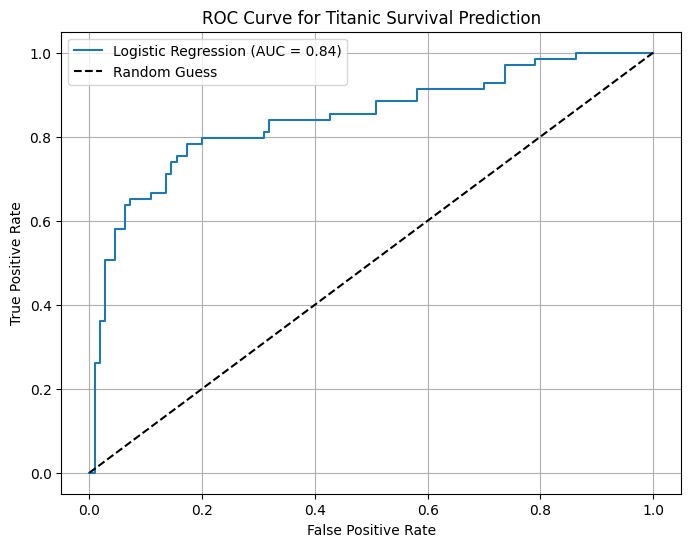

In [8]:
# 5. Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)
print(f"\nROC AUC Score: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Titanic Survival Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# 6. Classify a New Sample
print("Classifying a New Sample with Logistic Regression:")

# Example new sample: A male, 30 years old, 3rd class, 1 sibling/spouse, 0 parent/children, paid 15.0 for fare, embarked from S
new_sample_data = {
    'PassengerId': [999], # Dummy ID
    'Pclass': [3],
    'Name': ['New Sample'], # Dummy name
    'Sex': ['male'],
    'Age': [30.0],
    'SibSp': [1],
    'Parch': [0],
    'Ticket': ['SAMPLE123'], # Dummy ticket
    'Fare': [15.0],
    'Cabin': [np.nan], # Missing cabin
    'Embarked': ['S']
}
new_sample_df = pd.DataFrame(new_sample_data)

print(f"\nNew Sample to classify:\n{new_sample_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]}")

# Predict the class and probabilities for the new sample using the trained pipeline
new_sample_prediction = log_reg_pipeline.predict(new_sample_df)[0]
new_sample_prediction_proba = log_reg_pipeline.predict_proba(new_sample_df)[0]

survival_status = "Survived" if new_sample_prediction == 1 else "Did Not Survive"

print(f"\nThe new sample is predicted to: '{survival_status}'")
print("\nProbabilities:")
print(f"  Did Not Survive (0): {new_sample_prediction_proba[0]:.4f}")
print(f"  Survived (1): {new_sample_prediction_proba[1]:.4f}")


Classifying a New Sample with Logistic Regression:

New Sample to classify:
   Pclass   Sex   Age  SibSp  Parch  Fare Embarked
0       3  male  30.0      1      0  15.0        S

The new sample is predicted to: 'Did Not Survive'

Probabilities:
  Did Not Survive (0): 0.9318
  Survived (1): 0.0682
